# Objetivo
Implementar o algoritmo de partição **K-Means** usando a ideia de fatoração de matrizes.

# Método
- **Entrada**: Uma matriz $A_{mxn}$ que possui em cada coluna os **dados** que serão particionados e um número **k** de partições
- **Saída**: Duas Matrizes $B_{mxk}$ e $C_{kxn}$ de, respectivamente, **centróides** (vetores médios que representa uma partição) e **índices** (vetores que indicam qual centróide está mais próximo daquele vetor). Tais que $A \approx BC$.

Dessa forma, transformamos o problema de **particionamento** num problema de **fatoração aproximada de matrizes**. Entretanto, é um problema de fatoração mais complexo pois a matriz de índices (Matriz Indicadora) tem um formato específico (matriz esparsa, em que cada coluna só contém uma linha com o número $1$ e o resto é $0$.

# Um exemplo muito simples

Dados os pontos: (-2,3), (-1,4), (3,1), (4,1), (-1,-1), (-1,0).

Vamos colocá-los numa matriz $A_{2x6}$ que será a entrada para o algorítmo.

$$A = \begin{bmatrix}
-2 & -1 & 3 & 4 & -1 & -1 \\
3 & 4 & 1 & 1 & -1 & 0
\end{bmatrix} $$

Que visualmente estão distribuídos da seguinte forma:

In [1]:
import Pkg
#Pkg.add("Distances")
#Pkg.add("Plots")
#Pkg.add("MLJ")
using LinearAlgebra
using Distances
using SparseArrays
using Plots
using MLJ


(process:6824): GLib-GIO-WARNING **: 12:42:11.110: Unexpectedly, UWP app `Microsoft.OutlookForWindows_1.2023.727.100_x64__8wekyb3d8bbwe' (AUMId `Microsoft.OutlookForWindows_8wekyb3d8bbwe!Microsoft.OutlookforWindows') supports 1 extensions but has no verbs


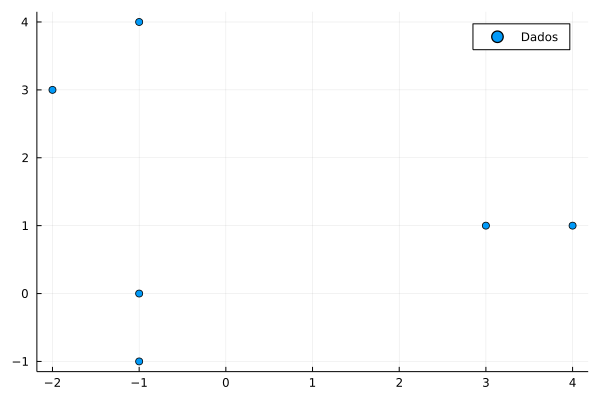

In [2]:
dados = [-2. -1 3 4 -1 -1;
          3  4 1 1 -1  0]
scatter([dados[1,:]], [dados[2,:]], label="Dados")

Intuitivamente podemos ver que deveríamos ter 3 partições, cada uma com 2 vetores, e cada centróide ficaria mais ou menos no meio dos dois vetores que ele representaria. 
Isso é, os vetores $(-2, 3)$ e $(-1, 4)$ ficarão associados ao vetor no meio deles $(-1.5, 3.5)$; os vetores $(3, 1)$ e $(4, 1)$ ficarão associados ao vetor no meio deles $(3.5, 1)$; os vetores $(-1, -1)$ e $(-1, 0)$ ficarão associados ao vetor no meio deles $(-1, -0.5)$;
Dessa forma, o resultado será:

$$A \approx BC $$

$$\begin{bmatrix}
-2 & -1 & 3 & 4 & -1 & -1 \\
3 & 4 & 1 & 1 & -1 & 0
\end{bmatrix} 
\approx
\begin{bmatrix}
3.5 & -1.5 & -1\\
1 & 3.5 & -0.5
\end{bmatrix} 
\begin{bmatrix}
0 & 0 & 1 & 1 & 0 & 0 \\
1 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 1
\end{bmatrix} 
$$

Que visualmente fica assim:

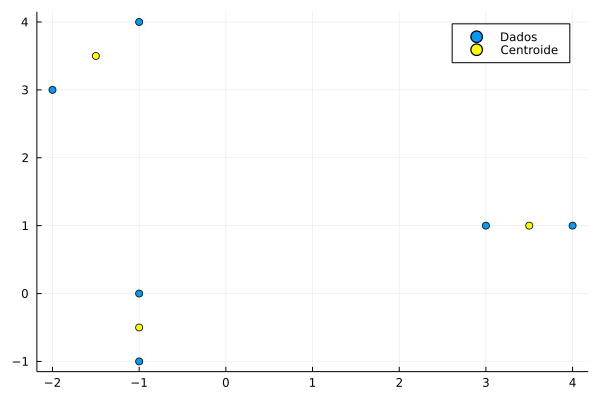

In [3]:
centroides = [3.5 -1.5 -1.0; 
             1.0  3.5 -0.5]
scatter!([centroides[1,:]], [centroides[2,:]], color=:yellow, label="Centroide")

Vamos, então, ao algoritmo que faz isso.

# Ideia do Algoritmo

Primeiramente, precisamos do ***k***, isso é, o número de partições ou centróides.

Com isso, inicialmente chutamos os centróides de forma aleatória e procuramos a melhor matriz Indicadora para eles, isso é, verificamos qual centróide está mais próximo de cada dado.

A partir dessa matriz Indicadora, iremos achar os melhores centróides, calculando o vetor médio entre os dados que estão atrelados a cada centróide.

A partir dos novos centróides, vamos achar a melhor matriz Indicadora. E assim por diante...

Vamos *alternando* entre achar a melhor matriz baseada na outra, até que elas comecem a estabilizar, ou seja, o **algoritmo convergir**.

# A melhor matriz Indicadora

Vamos começar implementando a função para encontrar a melhor matriz Indicadora, dadas as matrizes de Dados e de Centroides.

Para isso, precisamos percorrer cada dado e ver qual centroide ele está mais próximo e indicá-lo na coluna da matriz indicadora.

In [4]:
function melhorIndicadora(Dados, Centroides)
    m, n = size(Dados)
    _, qtdCentroides = size(Centroides)
    
    # calcula a distancia euclidiana entre cada dado e cada centroide
    distancias = pairwise(Euclidean(), Dados, Centroides, dims=2)
    
    # gera uma lista com indices dos centroides mais perto dos dados
    indices_menores_distancias = vec(map(index -> index[2], argmin(distancias, dims=2)))
    
    # cria a matriz Indicadora esparsa de tamanho kxn
    return sparse(indices_menores_distancias, collect(1:n), ones(n), qtdCentroides, n)
end

melhorIndicadora (generic function with 1 method)

# A melhor matriz de Centroides



Função para encontrar a melhor matriz de Centroides, dadas as matrizes de Dados e a Indicadora.

Os conjuntos de dados mais próximos de cada centróide irão representar os clusters. Para cada cluster, vamos calcular o vetor médio dele e usar como novo centróide. Então os clusters serão calculados novamente pela função _melhorIndicadora_.

In [14]:
function melhoresCentroides(Dados, Indicadora)
    m, n = size(Dados)
    
    # gera um vetor em que cada posição representa a quantidade de dados atrelados a cada centroide
    qtdPontosPorCentroide = Indicadora * ones(n)
    
    # cria uma matriz diagonal em que cada elemento é o inverso da quantidade de pontos em cada centroide
    invQtdPontosPorCentroide = pinv(diagm(qtdPontosPorCentroide))
    
    # cria uma matriz mxk em que cada coluna é a soma de todos os dados atrelados a um centroide
    somaVetores = Dados * Indicadora'
    
    # divide cada soma de vetores pela quantidade de dados por centroide, resultando no vetor médio
    Centroides = somaVetores * invQtdPontosPorCentroide
    
    return Centroides
end

melhoresCentroides (generic function with 1 method)

# Métrica de erro

Precisamos de uma métrica de erro para usar nas iterações e acompanhar até o algoritmo convergir. Vamos usar a norma de Frobenius como métrica de erro entre a matriz original A (Dados) e a Fatoração BC. Essa métrica consiste em calcular a diferença entre as duas matrizes e somar os quadrados de cada entrada do resultado, tirando a raiz quadrada no final. Por exemplo:

Se tivermos a matriz $$Dados - BC = \begin{bmatrix}a & b \\ c & d\end{bmatrix}$$

O erro será $$erro = \sqrt{a^2 + b^2 + c^2 + d^2}$$

In [15]:
function erroFatoracao(Dados, Centroides, Indicadora)
    BC = Centroides * Indicadora
    
    return norm(Dados - BC)
end

erroFatoracao (generic function with 1 method)

# Função final para o algoritmo

In [65]:
function kmeans(Dados, qtdClusters, epsilon=1e-8)
    m, n = size(Dados)
    
    # cria centroides aleatórios
    Centroides = randn(m, qtdClusters)
    Indicadora = melhorIndicadora(Dados, Centroides)
    
    erroAnterior = 0
    erroAtual = erroFatoracao(Dados, Centroides, Indicadora)
    
    # itera até que a diminuição do erro seja pequena
    while (abs(erroAtual - erroAnterior) >= epsilon)
        Centroides = melhoresCentroides(Dados, Indicadora)
        Indicadora = melhorIndicadora(Dados, Centroides)
        
        # atualiza os erros
        erroAnterior = erroAtual
        erroAtual = erroFatoracao(Dados, Centroides, Indicadora)
    end

    # cria uma lista com o indice do centróide atrelado a cada dado
    indices = vec(map(index -> index[2], argmax(Indicadora', dims=2)))
    
    return Centroides, Indicadora, indices
end

kmeans (generic function with 2 methods)

# Testando com um exemplo maior

Vamos criar um conjunto de dados sintéticos com 4 clusters com diferentes densidades

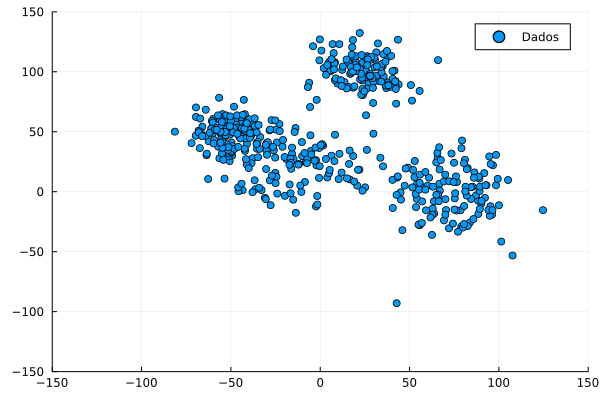

In [75]:
X, y = make_blobs(500, 2; centers=[-50 50; 25 100; -15 25; 75 0], cluster_std=[10, 12, 20, 20], center_box=(-100. => 100.))

scatter([X.x1], [X.x2], 
    label="Dados",
    ylimits=(-150,150),
    xlimits=(-150,150))

Executamos o algoritmo com os dados, indicando que queremos 4 clusters

In [68]:
dados2 = [X.x1'; X.x2']
Centroides, Indicadora, indices = kmeans(dados2, 4)

([28.249960070536577 -54.10490577861558 72.4276057845288 -15.076482411472467; 117.74305120210558 57.9537612267087 -0.7337407635281615 21.2232323510486], 
⠛⠙⠛⠛⠛⠛⠛⠛⠛⠛⠙⠛⠚⠛⠛⠓⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠓⠛⠛, [3, 3, 3, 1, 2, 4, 1, 2, 3, 1  …  1, 3, 3, 1, 3, 4, 2, 4, 2, 1])

### Resultado final

Temos quatro clusters, cada um de uma cor. E os centroides de cada cluster estão destacados em amarelo.

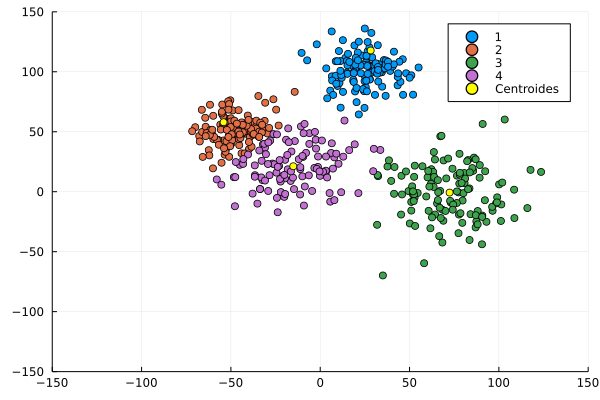

In [72]:
scatter([X.x1], [X.x2],
    group=indices,
    ylimits=(-150,150),
    xlimits=(-150,150))

scatter!([Centroides[1,:]], [Centroides[2,:]], 
    color=:yellow, 
    label="Centroides", 
    ylimits=(-150,150), 
    xlimits=(-150,150))

# Comparação de desempenho com a função original
Desenvolvi essa função dois anos atrás. Hoje com muito mais experiência em programação e álgebra linear, pude criar o código enxuto e otimizado acima. Mas além da estética e legibilidade, vamos comparar o desempenho delas!

In [77]:
function kmeans2(Dados, qtdClusters)
    function melhorIndicadora(Dados, Centroides)
        m, n = size(Dados)
        _, qtdCentroides = size(Centroides)
        Indicadora = zeros(qtdCentroides, n)
        
        # para cada vetor na matriz indicadora
        for i=1:n
            menorDistancia = norm(Centroides[:,1] - Dados[:,i])
            centroideMaisProximo = 1
            
            # verifica qual centroide está mais próximo do dado
            for j=2:qtdCentroides
                distancia = norm(Centroides[:,j] - Dados[:,i])
                
                if (distancia < menorDistancia)
                    menorDistancia = distancia
                    centroideMaisProximo = j
                end
            end
            
            # vetor da matriz indicadora: vetor com um e somente um elemento 1
            indicador = zeros(qtdCentroides, 1)
            indicador[centroideMaisProximo] = 1
            
            Indicadora[:,i] = indicador
        end
        
        return Indicadora    
    end
    
    function melhoresCentroides(Dados, Indicadora)
        m, n = size(Dados)
        qtdCentroides, _ = size(Indicadora)
        Centroides = zeros(m, qtdCentroides)
        
        # para cada vetor na matriz de centroides
        for i=1:qtdCentroides
            soma = zeros(m,1)
            qtdDePontos = 0
            indicador = zeros(qtdCentroides, 1)
            indicador[i] = 1
            
            # para cada elemento na matriz indicadora
            for j=1:n
                # verifica se o vetor da matriz indicadora se refere ao centroide atual
                if (norm(Indicadora[:,j] - indicador) <= 1e-8)
                    soma += Dados[:,j]
                    qtdDePontos += 1
                end
            end
            
            if (qtdDePontos != 0)
                Centroides[:,i] = soma / qtdDePontos
            end
        end
        
        return Centroides
    end
    
    function erroDistancia(Dados, Centroides, Indicadora)
        m, n = size(Dados)
        qtdCentroides, _ = size(Indicadora)
        erroTotal = 0
        
        # para cada vetor na matriz de centroides
        for i=1:qtdCentroides
            erroDoCentroide = 0
            indicador = zeros(qtdCentroides, 1)
            indicador[i] = 1
            
            # calcula a distância do centroide pro dado
            for j=1:n
                if (norm(Indicadora[:,j] - indicador) <= 1e-8)
                    erroDoCentroide += norm(Dados[:,j] - Centroides[:,i])
                end
            end
            
            erroTotal += erroDoCentroide
        end
        
        return erroTotal
    end
    
    m, n = size(Dados)
    
    
    #sorteia b aleatória com pontos dos dados
    Centroides = randn(m, qtdClusters)
    
    # primeira iteração
    Indicadora = melhorIndicadora(Dados, Centroides)
    erro = 0
    novoErro = erroDistancia(Dados, Centroides, Indicadora)
    
    # itera até que a diminuição do erro seja pequena
    while (abs(novoErro - erro) >= 1e-8)
        erro = novoErro
        Centroides = melhoresCentroides(Dados, Indicadora)
        Indicadora = melhorIndicadora(Dados, Centroides)
        novoErro = erroDistancia(Dados, Centroides, Indicadora)
    end
    
    return Centroides, Indicadora
end

kmeans2 (generic function with 1 method)

Dados Sintéticos para rodar o algoritmo

In [96]:
#import Pkg; Pkg.add("BenchmarkTools")
using BenchmarkTools

X, y = make_blobs(200000, 2; centers=[-50 50; 25 100; -15 25; 75 0], cluster_std=[10, 12, 20, 20], center_box=(-100. => 100.))
dados3 = [X.x1'; X.x2']

2×200000 Matrix{Float64}:
 -50.4869   19.8039  -44.5794  -35.8066  …  -62.6059  -60.7599   22.6452
  47.539   115.25     36.5273   46.6368      35.5828   71.7946  114.188

In [97]:
@time kmeans(dados3, 4)

  4.860988 seconds (841 allocations: 543.257 MiB, 1.07% gc time)


([24.943501904272104 75.55163294395034 -9.62466250272831 -48.06653714191707; 99.4404550170544 -0.23372157108598224 19.92580478424605 48.525638306247075], 
⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛⠛, [4, 1, 4, 4, 4, 4, 3, 1, 3, 1  …  1, 3, 3, 3, 4, 1, 2, 4, 4, 1])

In [98]:
@time kmeans2(dados3, 4)

 42.087908 seconds (765.58 M allocations: 22.581 GiB, 8.82% gc time)


([-9.62466250272831 75.55163294395034 24.943501904272104 -48.06653714191707; 19.92580478424605 -0.23372157108598224 99.4404550170544 48.525638306247075], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 1.0; 1.0 0.0 … 1.0 0.0])

### Resultado
A diferença de tempo de execução é enorme! Mas, ainda mais impressionante é a diferença de uso de memória, a segunda função usa __40 vezes mais__ memória!